In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries and Loading Data

In [8]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

file_path = "/content/drive/MyDrive/python(sem3)/Titanic-Dataset.csv"
data = pd.read_csv(file_path)
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Preprocessing

In [9]:

data['Age'] = data['Age'].fillna(data['Age'].mean())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

data_cleaned = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

data_encoded = pd.get_dummies(data_cleaned, columns=['Sex', 'Embarked'], drop_first=True)

X = data_encoded.drop(columns=['Survived']).values
y = data_encoded['Survived'].values

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Helper Functions for Softmax Regression

In [10]:

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-10)) / y_true.shape[0]

def compute_gradients(X, y_true, y_pred):
    n_samples = X.shape[0]
    grad_W = np.dot(X.T, (y_pred - y_true)) / n_samples
    grad_b = np.sum(y_pred - y_true, axis=0) / n_samples
    return grad_W, grad_b

def gradient_descent(X, y, W, b, alpha, n_iter):
    cost_history = []
    for _ in range(n_iter):
        z = np.dot(X, W) + b
        y_pred = softmax(z)
        cost = compute_loss(y, y_pred)
        cost_history.append(cost)
        grad_W, grad_b = compute_gradients(X, y, y_pred)
        W -= alpha * grad_W
        b -= alpha * grad_b
    return W, b, cost_history


### Training the Model

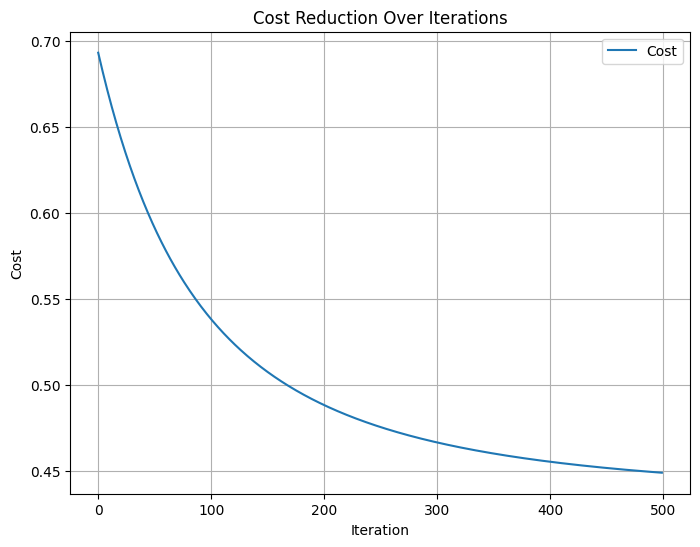

In [11]:

n_features = X_train_scaled.shape[1]
n_classes = y_train.shape[1]
W = np.zeros((n_features, n_classes))
b = np.zeros(n_classes)
learning_rate = 0.01
n_iterations = 500

W_opt, b_opt, cost_history = gradient_descent(X_train_scaled, y_train, W, b, learning_rate, n_iterations)

plt.figure(figsize=(8, 6))
plt.plot(range(n_iterations), cost_history, label="Cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Reduction Over Iterations")
plt.legend()
plt.grid()
plt.show()


### Evaluating the Model

In [12]:

def predict(X, W, b):
    z = np.dot(X, W) + b
    y_pred_prob = softmax(z)
    return np.argmax(y_pred_prob, axis=1)

def evaluate_model(X, y_true, W, b):
    y_pred = predict(X, W, b)
    y_true_labels = np.argmax(y_true, axis=1)
    accuracy = np.mean(y_pred == y_true_labels) * 100
    return accuracy, y_pred

test_accuracy, y_test_pred = evaluate_model(X_test_scaled, y_test, W_opt, b_opt)

y_test_true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred)
class_report = classification_report(y_test_true_labels, y_test_pred, target_names=["Did Not Survive", "Survived"])

print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Test Accuracy: 78.77%
Confusion Matrix:
[[95 15]
 [23 46]]
Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.81      0.86      0.83       110
       Survived       0.75      0.67      0.71        69

       accuracy                           0.79       179
      macro avg       0.78      0.77      0.77       179
   weighted avg       0.79      0.79      0.78       179

